# stella(r1) vs jina(r2) vs bm25(r3)

## Preprocessing

In [1]:
import json
from utilities import load_jsonl

fava_r1 = load_jsonl("/Users/jjr/output/rarr-rep/output/fava/fava_q1_r1_a1.jsonl")
fava_r2 = load_jsonl("/Users/jjr/output/rarr-rep/output/fava/fava_q1_r2_a1.jsonl")
fava_r3 = load_jsonl("/Users/jjr/output/rarr-rep/output/fava/fava_q1_r3_a1.jsonl")

wiki_r1 = load_jsonl("/Users/jjr/output/rarr-rep/output/wiki/wiki_q1_r1_a1.jsonl")
wiki_r2 = load_jsonl("/Users/jjr/output/rarr-rep/output/wiki/wiki_q1_r2_a1.jsonl")
wiki_r3 = load_jsonl("/Users/jjr/output/rarr-rep/output/wiki/wiki_q1_r3_a1.jsonl")

### --> add additional data to output data

In [2]:
# (number of queries, predicted error, agreement gates)

In [3]:
fava_input = load_jsonl("/Users/jjr/PycharmProjects/RARR-rep/input/processed/fava_input_processed.jsonl")
wiki_input = load_jsonl("/Users/jjr/PycharmProjects/RARR-rep/input/processed/wiki_input_processed.jsonl")
with open("/Users/jjr/Downloads/annotations.json", 'r') as f:
    annotations = json.load(f)

In [4]:
fava_input[0].keys()

dict_keys(['sid', 'pid', 'sentence_num', 'decon_sentence', 'annotated_sentence', 'error_count_dict', 'has_error', 'baseline_query_count'])

In [5]:
outputs = [fava_r1, fava_r2, fava_r3, wiki_r1, wiki_r2, wiki_r3]
output_names = ['fava_r1', 'fava_r2', 'fava_r3', 'wiki_r1', 'wiki_r2', 'wiki_r3']

for name, output in zip(output_names, outputs):
    if name.startswith('fava'):
        input_data = fava_input
    elif name.startswith('wiki'):
        input_data = wiki_input
    else:
        raise ValueError("problem identifying correct input data")
                        
    for i in range(len(output)):

        # add something from input data?
        if name.startswith('fava'):
            output[i]['error_count_dict'] = input_data[i]['error_count_dict']
        
        # number of queries
        num_queries = len(output[i]['queries'])
        output[i]['num_queries'] = num_queries
        
        # predicted error
        error_predicted = False
        gates = output[i]['agreement_gates']
        for gate in gates:
            if gate['score'] == 1:
                # only need one error
                error_predicted = True
                break
        output[i]['error_predicted'] = error_predicted

### --> create dataframes from output data

In [6]:
import pandas as pd

dfs_dict = {}
for name, output in zip(output_names, outputs):
    if name.startswith("wiki"):
        df = pd.DataFrame(output, columns=["sid", "pid", "decon_sentence", "has_error", "has_facts", "error_predicted", 
                                           "num_queries", "ret_iteration_time", "agr_iteration_time", 'agreement_gates'])
        # remove rows without facts
        df = df[df["has_facts"]]

    else:
        df = pd.DataFrame(output, columns=["sid", "pid", "decon_sentence", "has_error", "error_predicted",
                                           "num_queries", "ret_iteration_time", "agr_iteration_time", 'agreement_gates', 'error_count_dict'])
    dfs_dict[name] = df
    


In [7]:
dfs_dict['fava_r1']

,sid,pid,decon_sentence,has_error,error_predicted,num_queries,ret_iteration_time,agr_iteration_time,agreement_gates,error_count_dict
0,0,0,A neural network is a computer program designe...,False,True,8,13.785247,14.595356,"[{'is_open': True, 'reason': '4. Reasoning: Th...",{}
1,1,0,Artificial neurons in a neural network receive...,False,False,6,9.877836,11.408315,"[{'is_open': False, 'reason': '4. Reasoning: T...",{}
2,2,0,A neural network trained with a large amount o...,False,False,6,9.288616,10.747340,"[{'is_open': False, 'reason': '4. Reasoning: T...",{}
3,3,0,The more data a neural network is exposed to a...,False,True,4,7.443273,7.845278,"[{'is_open': True, 'reason': '4. Reasoning: Th...",{}
4,4,0,A neural network is a highly sophisticated dec...,False,True,4,6.751373,7.908742,"[{'is_open': False, 'reason': '4. Reasoning: T...",{}
...,...,...,...,...,...,...,...,...,...,...
5145,5145,459,A.S. Livorno Calcio has had several notable pl...,False,True,9,15.938987,15.300891,"[{'is_open': True, 'reason': '4. Reasoning: Th...",{}
5146,5146,459,A.S. Livorno Calcio's colors are red and white...,False,True,5,9.135243,7.893679,"[{'is_open': True, 'reason': '4. Reasoning: Th...",{}
5147,5147,459,The A.S. Livorno Calcio badge also features a ...,False,True,7,12.779220,11.764224,"[{'is_open': True, 'reason': '4. Reasoning: Th...",{}
5148,5148,459,A.S. Livorno Calcio's kit manufacturer is curr...,False,True,5,9.250289,7.359270,"[{'is_open': True, 'reason': '4. Reasoning: Th...",{}


### --> Add confusion matrix column to dataframe

In [8]:
def confusion_matrix_outcome(row):
    """
    Update the 'confusion_matrix' cell value based on the values of 'has_error' and 'error_predicted'.
    Input: a single dataframe row (as a Series).
    """
    if row['has_error'] and row['error_predicted']:
        row['confusion_matrix'] = 'tp'
    elif not row['has_error'] and row['error_predicted']:
        row['confusion_matrix'] = 'fp'
    elif row['has_error'] and not row['error_predicted']:
        row['confusion_matrix'] = 'fn'
    elif not row['has_error'] and not row['error_predicted']:
        row['confusion_matrix'] = 'tn'
    else:
        raise ValueError("Something is wrong with the outputs")
    
    return row
        
for name, df in dfs_dict.items():
    df = df.apply(confusion_matrix_outcome, axis=1)
    dfs_dict[name] = df
    

## --> Venn Diagrams: Queries and Evidence

In [9]:
queries_sets_dict = {}
evidence_sets_dict = {}


for name, output in zip(output_names, outputs):
    queries_sets_dict[name] = set()
    evidence_sets_dict[name] = set()
    for i in range(len(output)):
        # extract queries
        if output[i]['queries']:
            queries_sets_dict[name].update(output[i]['queries'])
        # extract evidence
        if output[i]['retrieved_evidence']:
            chunk_ids = [obj['chunked_id']
                         for sublist in output[i]['retrieved_evidence']
                         for obj in sublist]
            evidence_sets_dict[name].update(chunk_ids)

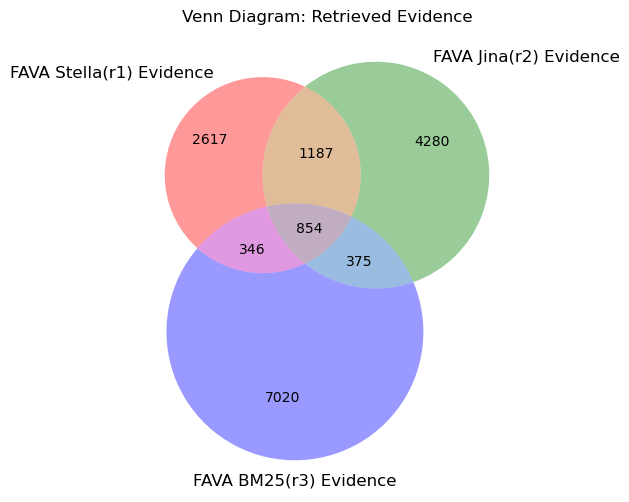

In [10]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

fava_r1_evidence_set = evidence_sets_dict['fava_r1']
fava_r2_evidence_set = evidence_sets_dict['fava_r2']
fava_r3_evidence_set = evidence_sets_dict['fava_r3']


# For Evidence
plt.figure(figsize=(6, 6))
venn3(
    subsets=(len(fava_r1_evidence_set - fava_r2_evidence_set - fava_r3_evidence_set),
             len(fava_r2_evidence_set - fava_r1_evidence_set - fava_r3_evidence_set),
             len(fava_r1_evidence_set & fava_r2_evidence_set - fava_r3_evidence_set),
             len(fava_r3_evidence_set - fava_r1_evidence_set - fava_r2_evidence_set),
             len(fava_r1_evidence_set & fava_r3_evidence_set - fava_r2_evidence_set),
             len(fava_r2_evidence_set & fava_r3_evidence_set - fava_r1_evidence_set),
             len(fava_r1_evidence_set & fava_r2_evidence_set & fava_r3_evidence_set)),
    set_labels=("FAVA Stella(r1) Evidence", "FAVA Jina(r2) Evidence", "FAVA BM25(r3) Evidence")
)
plt.title("Venn Diagram: Retrieved Evidence")
plt.show()

## --> Stacked bar chart

## --> Distribution of agreement scores

In [11]:
fava_r1_scores = []
for _,row in dfs_dict['fava_r1'].iterrows():
    gates = row['agreement_gates']
    for gate in gates:
        fava_r1_scores.append(gate['score'])
        
fava_r2_scores = []
for _,row in dfs_dict['fava_r2'].iterrows():
    gates = row['agreement_gates']
    for gate in gates:
        fava_r2_scores.append(gate['score'])
        
fava_r3_scores = []
for _,row in dfs_dict['fava_r3'].iterrows():
    gates = row['agreement_gates']
    for gate in gates:
        fava_r3_scores.append(gate['score'])

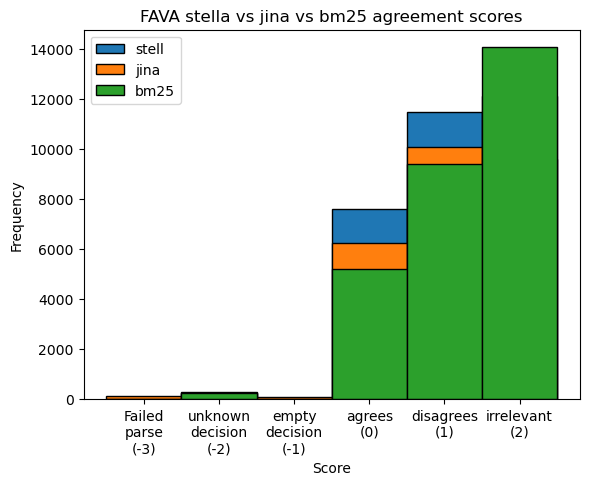

In [12]:
import matplotlib.pyplot as plt

# Example bins for scores from -2.5 to 2.5
bins = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5]

plt.hist(fava_r1_scores, bins=bins, edgecolor='black', label='stell')
plt.hist(fava_r2_scores, bins=bins, edgecolor='black', label='jina')
plt.hist(fava_r3_scores, bins=bins, edgecolor='black', label='bm25')
plt.legend(loc='upper left')

# Replace x-axis ticks with text: 
# -2 -> unknown, -1 -> empty, 0 -> agrees, etc.
plt.xticks(
    [-3, -2, -1, 0, 1, 2],               # positions
    [   "Failed\nparse\n(-3)",                             # labels
        "unknown\ndecision\n(-2)",
        "empty\ndecision\n(-1)",
        "agrees\n(0)",
        "disagrees\n(1)",
        "irrelevant\n(2)"
    ]
)

plt.title("FAVA stella vs jina vs bm25 agreement scores")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.show()

## --> Sankey 

## --> Calculate confusion matrix metrics

In [13]:
def calculate_cm_metrics(df):
    tp = len(df[(df['has_error'] == True) & (df['error_predicted'] == True)])
    fp = len(df[(df['has_error'] == False) & (df['error_predicted'] == True)])
    fn = len(df[(df['has_error'] == True) & (df['error_predicted'] == False)])
    tn = len(df[(df['has_error'] == False) & (df['error_predicted'] == False)])

    return {'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn}


results_dict = {}

for name, df in dfs_dict.items():
    result_dict = {}
    cm_metrics_dict = calculate_cm_metrics(df)
    tp = cm_metrics_dict['tp']
    fp = cm_metrics_dict['fp']
    tn = cm_metrics_dict['tn']
    fn = cm_metrics_dict['fn']

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    prevalence = df['has_error'].mean() 
    result_dict['precision'] = precision
    result_dict['recall'] = recall
    result_dict['prevalence'] = prevalence

    results_dict[name] = result_dict

In [14]:
results_dict

{'fava_r1': {'precision': 0.1732623033992897,
  'recall': 0.85375,
  'prevalence': np.float64(0.1553398058252427)},
 'fava_r2': {'precision': 0.1728492501973165,
  'recall': 0.82125,
  'prevalence': np.float64(0.1553398058252427)},
 'fava_r3': {'precision': 0.17056323060573858,
  'recall': 0.8025,
  'prevalence': np.float64(0.1553398058252427)},
 'wiki_r1': {'precision': 0.6670020120724346,
  'recall': 0.8655352480417755,
  'prevalence': np.float64(0.6182405165456013)},
 'wiki_r2': {'precision': 0.6503006012024048,
  'recall': 0.8472584856396866,
  'prevalence': np.float64(0.6182405165456013)},
 'wiki_r3': {'precision': 0.6519916142557652,
  'recall': 0.8120104438642297,
  'prevalence': np.float64(0.6182405165456013)}}

## --> Calculate statistical significance

In [15]:
from utilities import compare_stat_sig

dfA = dfs_dict['fava_r1']
dfB = dfs_dict['fava_r2']
compare_stat_sig(dfA,dfB,label_col='has_error',pred_col='error_predicted', alpha=0.05)

dfA = dfs_dict['wiki_r1']
dfB = dfs_dict['wiki_r2']
compare_stat_sig(dfA,dfB,label_col='has_error',pred_col='error_predicted', alpha=0.05)

===== RECALL COMPARISON (McNemar's test) =====
Recall contingency table: [[np.int64(598), np.int64(85)], [np.int64(59), np.int64(58)]]
McNemar's statistic: 4.3403
p-value:             0.03722
Significant at α=0.05? YES

===== PRECISION COMPARISON (McNemar's test) =====
Precision contingency table: [[np.int64(598), np.int64(85)], [np.int64(59), np.int64(3702)]]
McNemar's statistic: 4.3403
p-value:               0.03722
Significant at α=0.05? YES
===== RECALL COMPARISON (McNemar's test) =====
Recall contingency table: [[np.int64(605), np.int64(58)], [np.int64(44), np.int64(59)]]
McNemar's statistic: 1.6569
p-value:             0.198
Significant at α=0.05? NO

===== PRECISION COMPARISON (McNemar's test) =====
Precision contingency table: [[np.int64(605), np.int64(58)], [np.int64(44), np.int64(395)]]
McNemar's statistic: 1.6569
p-value:               0.198
Significant at α=0.05? NO


([[np.int64(605), np.int64(58)], [np.int64(44), np.int64(59)]],
 [[np.int64(605), np.int64(58)], [np.int64(44), np.int64(395)]])

In [16]:
from utilities import compare_stat_sig

dfA = dfs_dict['fava_r1']
dfB = dfs_dict['fava_r3']
compare_stat_sig(dfA,dfB,label_col='has_error',pred_col='error_predicted', alpha=0.05)

dfA = dfs_dict['wiki_r1']
dfB = dfs_dict['wiki_r3']
compare_stat_sig(dfA,dfB,label_col='has_error',pred_col='error_predicted', alpha=0.05)

===== RECALL COMPARISON (McNemar's test) =====
Recall contingency table: [[np.int64(585), np.int64(98)], [np.int64(57), np.int64(60)]]
McNemar's statistic: 10.3226
p-value:             0.001314
Significant at α=0.05? YES

===== PRECISION COMPARISON (McNemar's test) =====
Precision contingency table: [[np.int64(585), np.int64(98)], [np.int64(57), np.int64(3775)]]
McNemar's statistic: 10.3226
p-value:               0.001314
Significant at α=0.05? YES
===== RECALL COMPARISON (McNemar's test) =====
Recall contingency table: [[np.int64(562), np.int64(101)], [np.int64(60), np.int64(43)]]
McNemar's statistic: 9.9379
p-value:             0.001619
Significant at α=0.05? YES

===== PRECISION COMPARISON (McNemar's test) =====
Precision contingency table: [[np.int64(562), np.int64(101)], [np.int64(60), np.int64(405)]]
McNemar's statistic: 9.9379
p-value:               0.001619
Significant at α=0.05? YES


([[np.int64(562), np.int64(101)], [np.int64(60), np.int64(43)]],
 [[np.int64(562), np.int64(101)], [np.int64(60), np.int64(405)]])

## --> Plot hallucination detection

### ---> FAVA

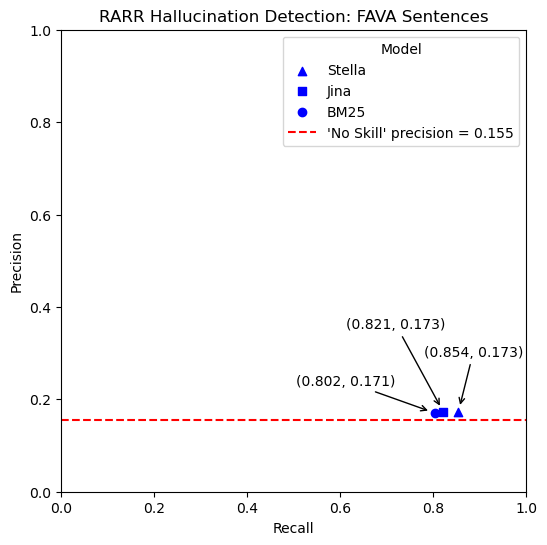

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

fava_r1_recall = results_dict['fava_r1']['recall']
fava_r1_precision = results_dict['fava_r1']['precision']

fava_r2_recall = results_dict['fava_r2']['recall']
fava_r2_precision = results_dict['fava_r2']['precision']

fava_r3_recall = results_dict['fava_r3']['recall']
fava_r3_precision = results_dict['fava_r3']['precision']


prevalence = results_dict['fava_r1']['prevalence']

plt.figure(figsize=(6, 6))  

# Plot the single points
plt.scatter(fava_r1_recall, fava_r1_precision, marker='^', color='blue', label='Stella')
plt.scatter(fava_r2_recall, fava_r2_precision, marker='s', color='blue', label='Jina')
plt.scatter(fava_r3_recall, fava_r3_precision, marker='o', color='blue', label='BM25')



# Annotate stella point
plt.annotate(
    f"({fava_r1_recall:.3f}, {fava_r1_precision:.3f})",
    xy=(fava_r1_recall, fava_r1_precision),   # point to label
    xycoords='data',
    xytext=(-25, 40),                          # shift annotation text (x=30, y=10) in "offset points"
    textcoords='offset points',
    arrowprops=dict(
        arrowstyle="->",
        connectionstyle="arc3",               # how arrow looks
        color='black',
        shrinkB=5
    ),
    ha='left'
)

# Annotate jina point
plt.annotate(
    f"({fava_r2_recall:.3f}, {fava_r2_precision:.3f})",
    xy=(fava_r2_recall, fava_r2_precision),
    xycoords='data',
    xytext=(-70, 60),  # shift annotation text to the left and downward
    textcoords='offset points',
    arrowprops=dict(
        arrowstyle="->",
        connectionstyle="arc3",
        color='black',
        shrinkB=5
    ),
    ha='left'
)


# Annotate bm25 point
plt.annotate(
    f"({fava_r3_recall:.3f}, {fava_r3_precision:.3f})",
    xy=(fava_r3_recall, fava_r3_precision),
    xycoords='data',
    xytext=(-100, 20),  # shift annotation text to the left and downward
    textcoords='offset points',
    arrowprops=dict(
        arrowstyle="->",
        connectionstyle="arc3",
        color='black',
        shrinkB=5
    ),
    ha='left'
)



# Add "No Skill" line
plt.axhline(y=prevalence, color='red', linestyle='--', 
            label=f'\'No Skill\' precision = {prevalence:.3f}')

# Add labels and legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(title="Model", loc="upper right")
plt.title("RARR Hallucination Detection: FAVA Sentences")
plt.grid(False)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

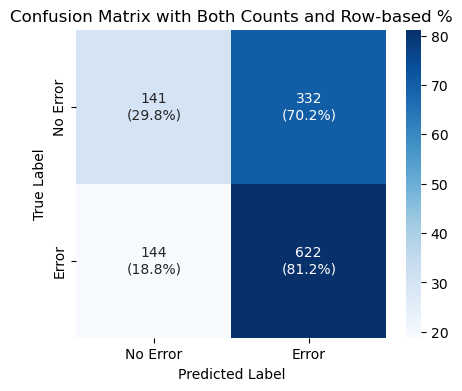

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = df['has_error'].astype(int)
y_pred = df['error_predicted'].astype(int)

# Calculate raw counts
cm = confusion_matrix(y_true, y_pred)  # shape is (2,2) for binary

# Row-based percentages: each row sums to 1 → multiply by 100 for percentage
cm_row_sum = cm.sum(axis=1, keepdims=True)
cm_percent = cm / cm_row_sum * 100  # each row sums to 100%

# Build a 2D array of strings showing count AND percentage
annot = np.empty_like(cm).astype(str)
n_rows, n_cols = cm.shape
for i in range(n_rows):
    for j in range(n_cols):
        c = cm[i, j]                       # raw count
        p = cm_percent[i, j]              # row-based percentage
        annot[i, j] = f"{c}\n({p:.1f}%)"  # e.g. "45\n(62.5%)"

# Turn `cm_percent` into a DataFrame for plotting
cm_df = pd.DataFrame(cm_percent, 
                     index=["No Error", "Error"], 
                     columns=["No Error", "Error"])

plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=annot, fmt="", cmap="Blues")  
# `fmt=""` so the annotation strings aren't formatted again

plt.title("Confusion Matrix with Both Counts and Row-based %")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### ---> WIKI

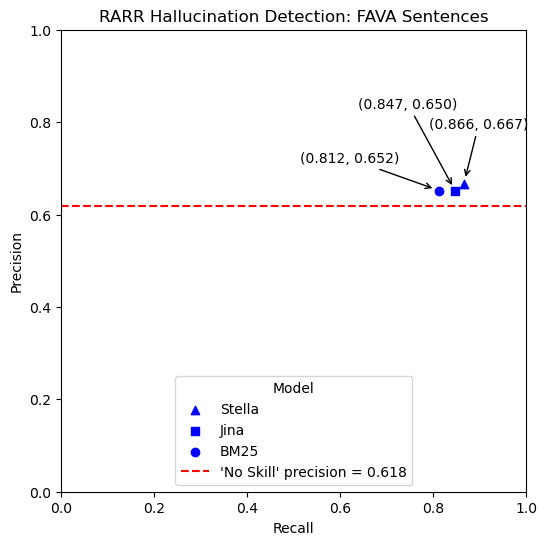

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

wiki_r1_recall = results_dict['wiki_r1']['recall']
wiki_r1_precision = results_dict['wiki_r1']['precision']

wiki_r2_recall = results_dict['wiki_r2']['recall']
wiki_r2_precision = results_dict['wiki_r2']['precision']

wiki_r3_recall = results_dict['wiki_r3']['recall']
wiki_r3_precision = results_dict['wiki_r3']['precision']


prevalence = results_dict['wiki_r1']['prevalence']

plt.figure(figsize=(6, 6))  

# Plot the single points
plt.scatter(wiki_r1_recall, wiki_r1_precision, marker='^', color='blue', label='Stella')
plt.scatter(wiki_r2_recall, wiki_r2_precision, marker='s', color='blue', label='Jina')
plt.scatter(wiki_r3_recall, wiki_r3_precision, marker='o', color='blue', label='BM25')



# Annotate stella point
plt.annotate(
    f"({wiki_r1_recall:.3f}, {wiki_r1_precision:.3f})",
    xy=(wiki_r1_recall, wiki_r1_precision),   # point to label
    xycoords='data',
    xytext=(-25, 40),                          # shift annotation text (x=30, y=10) in "offset points"
    textcoords='offset points',
    arrowprops=dict(
        arrowstyle="->",
        connectionstyle="arc3",               # how arrow looks
        color='black',
        shrinkB=5
    ),
    ha='left'
)

# Annotate jina point
plt.annotate(
    f"({wiki_r2_recall:.3f}, {wiki_r2_precision:.3f})",
    xy=(wiki_r2_recall, wiki_r2_precision),
    xycoords='data',
    xytext=(-70, 60),  # shift annotation text to the left and downward
    textcoords='offset points',
    arrowprops=dict(
        arrowstyle="->",
        connectionstyle="arc3",
        color='black',
        shrinkB=5
    ),
    ha='left'
)


# Annotate bm25 point
plt.annotate(
    f"({wiki_r3_recall:.3f}, {wiki_r3_precision:.3f})",
    xy=(wiki_r3_recall, wiki_r3_precision),
    xycoords='data',
    xytext=(-100, 20),  # shift annotation text to the left and downward
    textcoords='offset points',
    arrowprops=dict(
        arrowstyle="->",
        connectionstyle="arc3",
        color='black',
        shrinkB=5
    ),
    ha='left'
)



# Add "No Skill" line
plt.axhline(y=prevalence, color='red', linestyle='--', 
            label=f'\'No Skill\' precision = {prevalence:.3f}')

# Add labels and legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(title="Model", loc="lower center")
plt.title("RARR Hallucination Detection: FAVA Sentences")
plt.grid(False)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

# Query-Document Relevance

## -> Load results

In [35]:
fava_r1 = load_jsonl("/Users/jjr/output/rarr-rep/output/fava/fava_q1_r1_a1.jsonl")
fava_r2 = load_jsonl("/Users/jjr/output/rarr-rep/output/fava/fava_q1_r2_a1.jsonl")
fava_r3 = load_jsonl("/Users/jjr/output/rarr-rep/output/fava/fava_q1_r3_a1.jsonl")

wiki_r1 = load_jsonl("/Users/jjr/output/rarr-rep/output/wiki/wiki_q1_r1_a1.jsonl")
wiki_r2 = load_jsonl("/Users/jjr/output/rarr-rep/output/wiki/wiki_q1_r2_a1.jsonl")
wiki_r3 = load_jsonl("/Users/jjr/output/rarr-rep/output/wiki/wiki_q1_r3_a1.jsonl")

In [28]:
import pickle
# load main results dictionary
with open("/Users/jjr/output/rarr-rep/gemini_labels/query-evidence/failed_api_calls_dict.pkl", "rb") as f:
    failed_api_calls_dict = pickle.load(f)

In [29]:
failed_api_calls_dict

{}

In [30]:
import pickle
# load main results dictionary
with open("/Users/jjr/output/rarr-rep/gemini_labels/query-evidence/query_evidence_labels_dict.pkl", "rb") as f:
    query_evidence_labels_dict = pickle.load(f)


In [31]:
# identify retrieval groups included

# add q,e pairs for additional retrieval groups (do this is gemini_labelling)

# extract q,e pairs for each retrieval group

# plot horizontal stacked for each retrrieval group


In [32]:
import random

key, value = random.choice(list(query_evidence_labels_dict.items()))
print(key, value)

('Are Ethiopian citizens eligible for Singapore Visa-Free Entry scheme?', '40678427_0') {'M': 0, 'T': 1, 'O': 0}


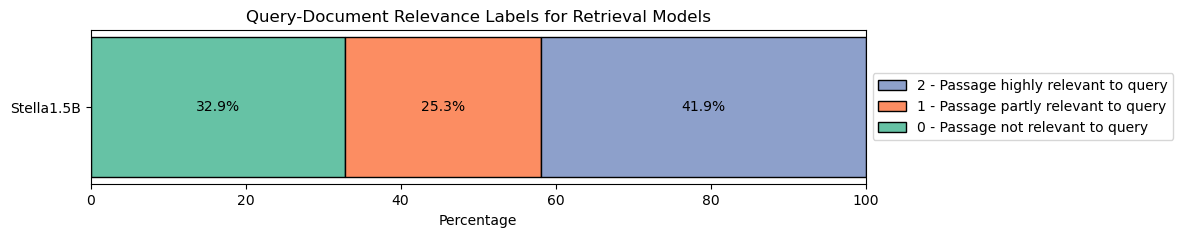

In [33]:
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.patches import Patch

# Extract the 'O' values from your dictionary
o_values = [subdict['O'] for subdict in query_evidence_labels_dict.values() if 'O' in subdict]

# Count occurrences for each of the three categories (0, 1, 2)
counts = Counter(o_values)
categories = [0, 1, 2]
counts_list = [counts.get(cat, 0) for cat in categories]

# Calculate percentages so that they sum to 100%
total = sum(counts_list)
percentages = [(count / total) * 100 for count in counts_list]

# Define colors for each segment (customize as needed)
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 2))
bar_label = "Stella1.5B"  # label for the horizontal bar (y-axis tick)

left = 0  # starting point for the first segment
for idx, (cat, perc) in enumerate(zip(categories, percentages)):
    ax.barh(bar_label, perc, left=left, color=colors[idx], edgecolor='black')
    
    # Optionally add text in the middle of each segment if wide enough
    if perc > 5:  # only label segments wider than 5% for readability
        ax.text(left + perc/2, 0, f"{perc:.1f}%", 
                va='center', ha='center', color='black', fontsize=10)
    left += perc  # update the starting point for the next segment

# Format the x-axis to show 0% to 100%
ax.set_xlim(0, 100)
ax.set_xlabel("Percentage")
ax.set_title("Query-Document Relevance Labels for Retrieval Models")

legend_elements = [
    Patch(facecolor=colors[2], edgecolor='black', label="2 - Passage highly relevant to query"),
    Patch(facecolor=colors[1], edgecolor='black', label="1 - Passage partly relevant to query"),
    Patch(facecolor=colors[0], edgecolor='black', label="0 - Passage not relevant to query")
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

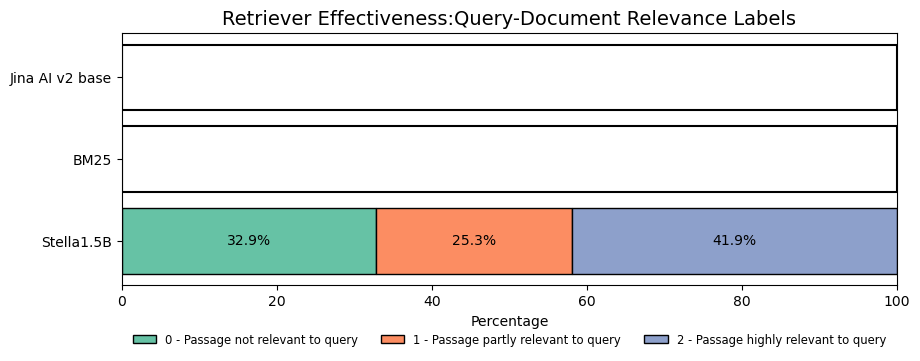

In [34]:
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.patches import Patch

# --- Data for "Stella1.5B" (stacked bar) ---

# Extract the 'O' values from your dictionary.
o_values = [subdict['O'] for subdict in query_evidence_labels_dict.values() if 'O' in subdict]

# Count occurrences for each category (0, 1, 2)
counts = Counter(o_values)
categories = [0, 1, 2]
counts_list = [counts.get(cat, 0) for cat in categories]

# Calculate percentages so that they sum to 100%
total = sum(counts_list)
percentages = [(count / total) * 100 for count in counts_list]

# Define colors for each category:
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# --- Set up the figure and adjust layout for a bottom legend ---
fig, ax = plt.subplots(figsize=(10, 4))
# Reserve extra space at the bottom for the legend
plt.subplots_adjust(bottom=0.25)

# Define y-axis labels and positions for the three bars.
y_labels = ["Stella1.5B", "BM25", "Jina AI v2 base"]
y_positions = [0, 1, 2]
ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels)

# --- Plot the bars ---

# 1. "Stella1.5B": Draw the stacked bar using the computed percentages.
stella_y = y_positions[0]
left = 0  # Starting x-position for the first segment
for idx, perc in enumerate(percentages):
    ax.barh(stella_y, perc, left=left, color=colors[idx], edgecolor='black')
    # Add text label if the segment is wide enough (here, > 5%)
    if perc > 5:
        ax.text(left + perc/2, stella_y, f"{perc:.1f}%", va='center', ha='center', 
                color='black', fontsize=10)
    left += perc

# 2. "BM25": Draw an empty bar (only an outline spanning 0–100%)
ax.barh(y_positions[1], 100, color='none', edgecolor='black', linewidth=1.5)

# 3. "Jina AI v2 base": Draw an empty bar (only an outline spanning 0–100%)
ax.barh(y_positions[2], 100, color='none', edgecolor='black', linewidth=1.5)

# --- Formatting the plot ---
ax.set_xlim(0, 100)
ax.set_xlabel("Percentage")
ax.set_title("Retriever Effectiveness:Query-Document Relevance Labels", fontsize=14)

# --- Create a flattened legend and place it below the x-axis label ---
legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label="0 - Passage not relevant to query"),
    Patch(facecolor=colors[1], edgecolor='black', label="1 - Passage partly relevant to query"),
    Patch(facecolor=colors[2], edgecolor='black', label="2 - Passage highly relevant to query")
]

# Position the legend at the bottom of the plot area.
ax.legend(handles=legend_elements,
          loc='upper center',
          bbox_to_anchor=(0.5, -0.15),  # Adjust y-value as needed
          ncol=3,
          fontsize='small',
          frameon=False)

plt.show()